# Preamble

Import necessary packages and setup logging.

In [ ]:
from dolfin import *
import numpy as np

import sys
sys.path.append( "./hippylib" )
from hippylib import *

import logging

import matplotlib.pyplot as plt
sys.path.append( "./hippylib/tutorial" )
import nb

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)


# Setup Function Spaces


In [3]:
# TODO: Pick the spaces carefully
nx = 64
ny = 64
mesh = UnitSquareMesh(nx, ny)
Vs = FunctionSpace(mesh, 'Lagrange', 1)
Vu = FunctionSpace(mesh, 'Lagrange', 2)


In [12]:
# TODO: Initialize these to the right values
# The true and inverted parameter
sigma_true = interpolate(Expression('0.3 + 0.2 * sin(4 * pi * x[0]) * sin(4 * pi * x[1])', degree=5),Vs)
sigma = interpolate(Expression('0.3', degree=1),Vs)

mu_true = interpolate(Expression('log(2 + 7*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2),0.5) > 0.2))', degree=5),Vs)
mu = interpolate(Expression('0.3', degree=1),Vs)

plt.figure(figsize=[12,24])
plt.subplot(1,2,1)
plot(sigma_true, title="True sigma")
plt.subplot(1,2,2)
plot(mu_true, title="True mu")
plt.colorbar()
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

# Problem 3

Image denoising using Tikhonov and total variation regularization methods

## Setup

Load in the noisy and the original image

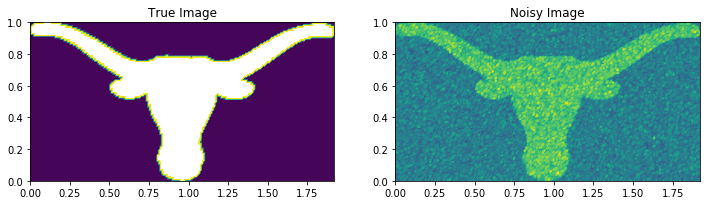

In [3]:
# Set the level of noise:
noise_std_dev = .3

# Load the image from file
data = np.loadtxt('image.dat', delimiter=',')
np.random.seed(seed=1)
noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])

# Set up the domain and the finite element space.
Lx = float(data.shape[1])/float(data.shape[0])
Ly = 1.

mesh = RectangleMesh(Point(0,0),Point(Lx,Ly),200, 100)
V = FunctionSpace(mesh, "Lagrange",1)

# Generate the true image (u_true) and the noisy data (u_0)
class Image(Expression):
    def __init__(self, Lx, Ly, data, **kwargs):
        self.data = data
        self.hx = Lx/float(data.shape[1]-1)
        self.hy = Ly/float(data.shape[0]-1)
        
    def eval(self, values, x):
        j = int(math.floor(x[0]/self.hx))
        i = int(math.floor(x[1]/self.hy))
        values[0] = self.data[i,j]

trueImage = Image(Lx,Ly,data, degree=1)
noisyImage = Image(Lx,Ly,data+noise, degree=1)
u_true  = interpolate(trueImage, V)
u_0 = interpolate(noisyImage, V)

plt.figure(figsize=[12,24])
plt.subplot(1,2,1)
plot(u_true, title="True Image")
plt.subplot(1,2,2)
plot(u_0, title="Noisy Image")
plt.show()

## Part (a)

Solving the denoising problem with Tikhonov regularization

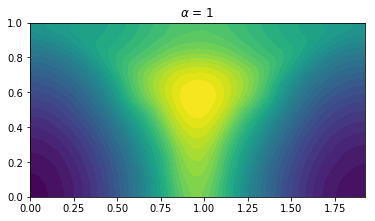

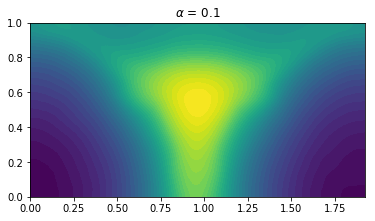

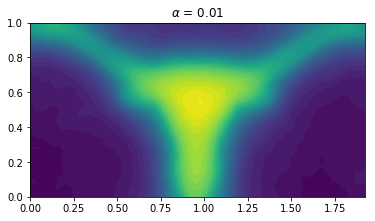

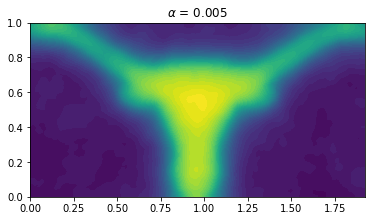

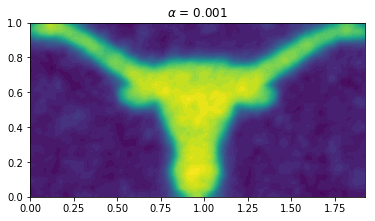

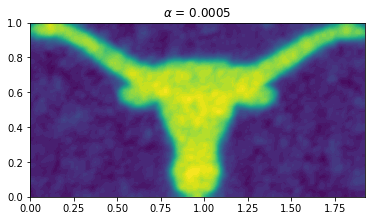

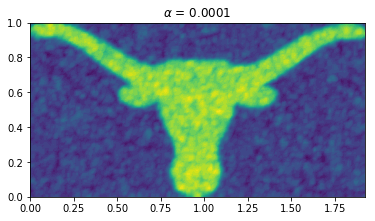

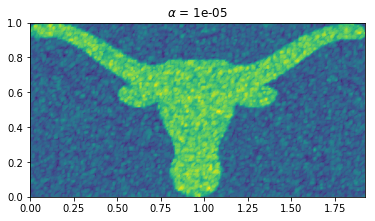

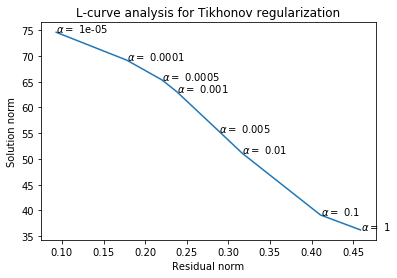

In [4]:
uh = TrialFunction(V)
vh = TestFunction(V)


def A_form(al):
    alpha = Constant(al)
    return uh*vh*dx + alpha * inner(grad(uh), grad(vh))*dx

def Objective(u, al):
    alpha = Constant(al)
    F = Constant(.5) * (u - u_0) * (u - u_0) * dx
    return math.sqrt(assemble(F))

alphas = [1,1e-1,1e-2,5e-3,1e-3,5e-4,1e-4, 1e-5]
u = Function(V)
sol_norms = []
res_norms = []

for al in alphas:
    a = A_form(al)
    L = u_0*vh*dx
    solve(a == L, u)
    plot(u, title=r'$\alpha$ = {}'.format(al))
    res_norms.append(Objective(u,al))
    sol_norms.append(np.linalg.norm(u.vector().array()))
    plt.show()

fig, ax = plt.subplots()    
ax.plot(res_norms, sol_norms)
for i, alpha in enumerate(alphas):
    ax.annotate(r'$\alpha =$ {}'.format(alpha),(res_norms[i],sol_norms[i]))
plt.xlabel("Residual norm")
plt.ylabel("Solution norm")
plt.title("L-curve analysis for Tikhonov regularization")
plt.show()

### Picking alpha

Looking at the L-curve and the reconstructions for different alpha, alpha = 0.001 seems to be the best choice. 

## Part (b)

Solving the denoising inverse problem using total variation regularization

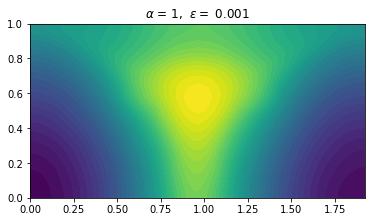

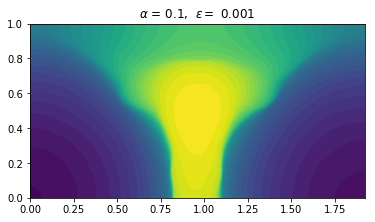

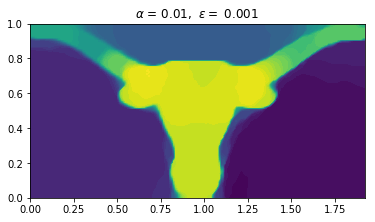

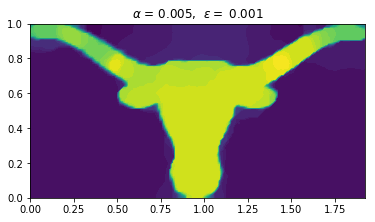

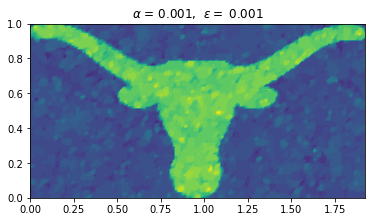

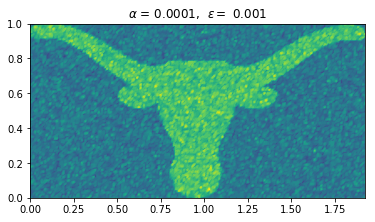

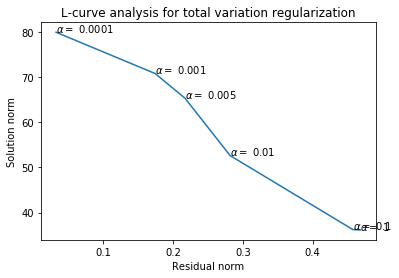

Epsilon: 10
Norm of the gradient less than tolerance
Inexact Newton CG converged in  25 nonlinear iterations and  443 linear iterations.
Final norm of the gradient 1.8621263737701044e-08
Value of the cost functional 0.09371947750668111


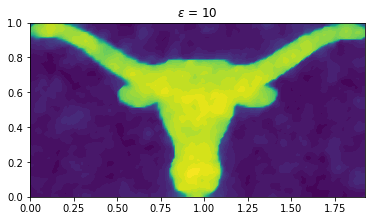

Epsilon: 1
Norm of the gradient less than tolerance
Inexact Newton CG converged in  12 nonlinear iterations and  459 linear iterations.
Final norm of the gradient 8.667559096459972e-09
Value of the cost functional 0.07598242190837375


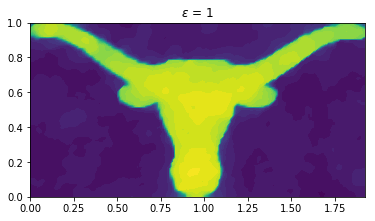

Epsilon: 0.1
Norm of the gradient less than tolerance
Inexact Newton CG converged in  8 nonlinear iterations and  475 linear iterations.
Final norm of the gradient 1.813147208126931e-08
Value of the cost functional 0.0707492242013692


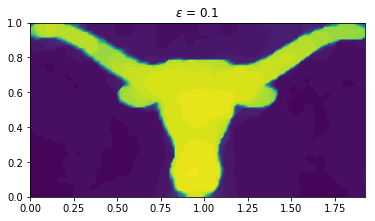

Epsilon: 0.01
Norm of the gradient less than tolerance
Inexact Newton CG converged in  10 nonlinear iterations and  500 linear iterations.
Final norm of the gradient 4.030671562071835e-09
Value of the cost functional 0.06922066768282133


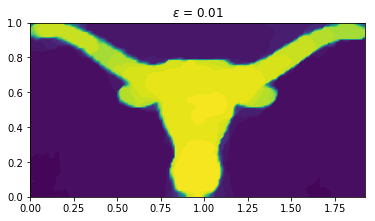

Epsilon: 0.001
Norm of the gradient less than tolerance
Inexact Newton CG converged in  32 nonlinear iterations and  571 linear iterations.
Final norm of the gradient 1.2771069890298538e-10
Value of the cost functional 0.06877437233682107


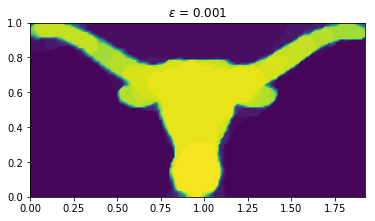

Epsilon: 0.0001
Norm of the gradient less than tolerance
Inexact Newton CG converged in  42 nonlinear iterations and  666 linear iterations.
Final norm of the gradient 3.076105900702228e-10
Value of the cost functional 0.06864248193026519


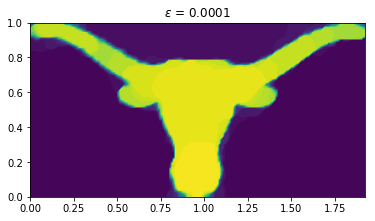

In [6]:
from unconstrainedMinimization import InexactNewtonCG

uh = Function(V)
u_tilde = TrialFunction(V)
vh = TestFunction(V)
du = Function(V)

def forms(EPSILON, ALPHA):
    alpha = Constant(ALPHA)
    epsilon = Constant(EPSILON)
    R_tv = sqrt(inner(nabla_grad(uh),nabla_grad(uh)) + epsilon)
    F = Constant(.5) * (uh - u_0) * (uh - u_0) * dx + alpha * R_tv * dx
    grad = (uh - u_0)*vh*dx + alpha * inner(nabla_grad(uh),nabla_grad(vh)) / R_tv * dx
    H = u_tilde * vh * dx + \
            alpha * inner(nabla_grad(u_tilde),nabla_grad(vh)) / R_tv * dx - \
            alpha * inner(nabla_grad(uh),nabla_grad(u_tilde)) * \
            inner(nabla_grad(uh), nabla_grad(vh)) / (R_tv ** 3) * dx

    return F,grad,H

solver = InexactNewtonCG()
solver.parameters["max_iter"] = 100
solver.parameters["rel_tolerance"] = 1e-5

alphas = [1, 1e-1, 1e-2, 5e-3,1e-3, 1e-4]
solver.parameters["print_level"] = -2
sol_norms = []
res_norms = []
eps = 1e-3
for al in alphas:
    (F, grad, H) = forms(eps, al)
    solver.solve(F, uh, grad, H)
    plot(uh, title=r'$\alpha$ = {},  $\epsilon = $ {}'.format(al,eps) )
    plt.show()
    sol_norms.append(np.linalg.norm(uh.vector().array()))
    res_norms.append(Objective(uh,al))

fig, ax = plt.subplots()    
ax.plot(res_norms, sol_norms)
for i, alpha in enumerate(alphas):
    ax.annotate(r'$\alpha =$ {}'.format(alpha),(res_norms[i],sol_norms[i]))
plt.xlabel("Residual norm")
plt.ylabel("Solution norm")
plt.title("L-curve analysis for total variation regularization")
plt.show()

epsilons = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4]
al = 5e-3 #Optimal alpha selected from previous analysis
solver.parameters["print_level"] = 0

for eps in epsilons:
    print ("Epsilon: {}".format(eps))
    (F, grad, H) = forms(eps, al)
    solver.solve(F, uh, grad, H)
    plot(uh, title=r'$\epsilon$ = {}'.format(eps) )
    plt.show()
    plt.cla()
    plt.clf()

### Picking alpha

The L-curve analysis and observation implies a values of 0.005 for alpha. This analysis was performed by setting epsilon to a small value to retain the ability to perform reconstructions with strong edges.

### Dependence on nonlinear iterations with varying epsilon

The number of nonlinear iterations increase with smaller epsilon as expected. As the footnote suggests, there are more efficient methods for solving TV-regularized inverse problems for small epsilon.

## Part (c)

The denoised reconstructions using TN-regularization trade off between noisiness and preserving sharp edges. As we reduce noise, the image loses its definition and we have a blurry output. But using TV-regularization, we are able to reduce the noise but preserving sharp edges. This is in line with the theoretical insight from question 1. 